In [1]:
from scipy.stats.mstats import winsorize
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from itertools import chain
import datetime as dt
import zipfile
import gzip
import warnings
warnings.filterwarnings("ignore")
import matplotlib.dates as mdates
import config
from pathlib import Path

OUTPUT_DIR = Path(config.OUTPUT_DIR)
DATA_DIR = Path(config.DATA_DIR)
START_DATE = config.START_DATE
END_DATE = config.END_DATE

In [2]:
# Change default pandas display options
pd.options.display.max_columns = 25
pd.options.display.max_rows = 500
pd.options.display.max_colwidth = 100
pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Change default figure size
plt.rcParams['figure.figsize'] = 6, 5

# Import Cleaned Data

- We are going to use the cleaned data to derive the table1. This dataframe contains the daily data of different bonds about bid ask spread, bid ask (cross-sectional winsorized) bias, daily return, credit spread, and ratong category.

In [3]:
daily_data = pd.read_csv('..'/ Path(DATA_DIR) / 'pulled' / 'daily.csv')

In [4]:
SUBSAMPLES = {
    'Full sample': ('2002-07-01', '2022-09-30'),
    'Pre-crisis': ('2002-07-01', '2007-06-30'),
    'Crisis': ('2007-07-01', '2009-04-30'),
    'Post-Crisis': ('2009-05-01', '2012-05-31'),
    'Basel II.5 & III': ('2012-06-01', '2014-03-31'),
    'Post-Volcker': ('2014-04-01', '2022-09-30'),
    'Recent':('2022-10-01', '2023-06-30'),
}

In [5]:
daily_data.head(5)

,cusip_id,date,spread,winsorized_bias,daily_return_bps,cs_dur_bps,category
0,000361AQ8,2013-02-20,12.7842,0.0041,-43.6070,501.4413,Junk
1,000361AQ8,2013-02-21,23.3372,0.0136,54.7528,495.0472,Junk
2,000361AQ8,2013-02-26,23.6008,0.0139,21.9664,502.0523,Junk
3,000361AQ8,2013-02-28,4.6179,0.0005,86.7520,488.2790,Junk
4,000361AQ8,2013-10-01,-67.4436,0.1137,-275.7585,463.9937,Junk


## Summary Statistics

- Note that all metrics has large range between the min and max, indicating that there are extreme values, and all the standard deviations indicate considerable variability among the data.

- 1. Bid Ask Spread:

    - Note that we did not exclude the negative bid ask spread, so the min of spread reaches to -13.38 bps. However, from the quantiles, we can see that most spreads are positive.

    - 25% of the spreads are less than or equal to 18.1036, 50% (median) are less than or equal to 30.3522, and 75% are less than or equal to 43.6666, showing that most spreads are concentrated in the lower range, which corresponds to the fact that the cleaned data tilts the daily sample toward a more **liquid** subset of corporate bond price.

- 2. Return
    - The average daily return is small at 1.9293 bps.
    - A very high standard deviation relative to the mean (35.8667) indicates large fluctuations in daily returns.
    - The min daily return is significantly negative (-410.4720 bps), which could signify a substantial loss.
    - The maximum daily return is exceptionally high (1250.0001 bps), pointing to some days with very large gains.

- 3. Bid ask Bias
    - A small average value of mean 0.1387 suggests a slight bias after winsorizing the data to reduce the influence of extreme values. 
    - The standard deviation is small (0.1501), indicating that the winsorized biases are generally close to the mean.
    - The max is 1.8348, showing that even after winsorization, there can be considerable positive bias.

- 4. Credit Spread
    - A mean of 329.0970 bps suggests that on average, the credit risk is regarded as moderate but significant.
    - The large standard deviation indicates a wide variation in credit spread across different bonds, which is reasonable since our data captured both the investment grades bond as well as junk bonds.
    - The very high max of 6053.5415 bps suggests that for some bonds, the crdit risk is extremely high, which might reflect high yield or distressed bonds.

In [6]:
# Group by date
summary_stats = daily_data.groupby('date')[['spread', 'winsorized_bias', 'daily_return_bps', 'cs_dur_bps']].mean()
summary_stats.describe()

,spread,winsorized_bias,daily_return_bps,cs_dur_bps
count,5285.0000,5285.0000,5285.0000,5285.0000
mean,33.9688,0.1387,1.9293,329.0970
std,21.6720,0.1501,35.8667,204.1760
min,-13.3777,0.0000,-410.4720,-5.5759
25%,18.1036,0.0348,-9.3749,208.4829
50%,30.3522,0.0869,2.9609,285.7494
75%,43.6666,0.1857,13.7768,388.6696
max,272.1646,1.8348,1250.0001,6053.5415


In [12]:
# Write to Latex
float_format_func = lambda x: '{:.3f}'.format(x)
latex_table_string = summary_stats.describe().to_latex(float_format=float_format_func)
path = f'../{OUTPUT_DIR}/summary_stats.tex'
with open(path, "w") as text_file:
    text_file.write(latex_table_string)

In [13]:
# Groupby date and category
data_categorized = daily_data.groupby(['category','date'])[['spread', 'winsorized_bias', 'daily_return_bps', 'cs_dur_bps']].mean()
data_categorized

spread  winsorized_bias  daily_return_bps  cs_dur_bps
category    date                                                              
A and above 2002-07-02  87.4012           0.4550           23.2719    155.6163
            2002-07-03 100.1334           0.4731           16.8466    165.9176
            2002-07-05  67.6379           0.3367          -27.8864    155.3119
            2002-07-08  68.8280           0.4538          -36.3166    160.0762
            2002-07-09  60.0263           0.3269           31.5691    161.2918
...                         ...              ...               ...         ...
Junk        2022-12-23  17.2662           0.0293           -8.4790    285.4185
            2022-12-27  16.2741           0.0305          -45.3333    281.0832
            2022-12-28  13.2843           0.0372          -43.3191    288.7147
            2022-12-29  15.0656           0.0385            0.3491    298.0561
            2022-12-30  15.1240           0.0363           -7.2443    300.0469

[15684 rows x 4 columns]

In [14]:
def plot_summary_stats(summary_stats, name, subsamples=SUBSAMPLES):
    '''
    Since the data is cross-sectional, 
    we are going to use the average of all bonds on a specific date.
    This function is used to plot the time series of metrics (mean) across bonds
    '''
    df = summary_stats[[name]]
    df.index = pd.to_datetime(df.index)
    fig, ax = plt.subplots(figsize=(10,5), dpi=200)
    ax.plot(df, label = name)
    ax.set_xlabel('Date')
    ax.set_ylabel(f'Cross Bonds {name}')
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth = None, interval=30))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    ax.set_title(f'Time Series of {name} across bonds')

    for subsample, (start, end) in subsamples.items():
        start = pd.to_datetime(start)
        end = pd.to_datetime(end)
        ax.axvline(x=start, color='black', linestyle='--', lw=1, label=f'Start of {subsample}')
        ax.axvline(x=end, color='red', linestyle='--', lw=1, label=f'End of {subsample}')
    
    # Improve layout to accommodate the legends
    fig.autofmt_xdate()
    fig.tight_layout()


In [15]:
def plot_categorized(data_categorized, name, subsamples=SUBSAMPLES):
    '''
    This function is used to plot the time series of metrics (mean) across bonds 
    with the bonds being categorized into different rating groups
    '''
    summary_pivoted = data_categorized.reset_index().pivot(index='date', columns='category', values=['spread', 'winsorized_bias', 'daily_return_bps', 'cs_dur_bps'])
    df = summary_pivoted[[name]]
    df.index = pd.to_datetime(df.index)
    fig, ax = plt.subplots(figsize=(10,5), dpi=200)
    ax.plot(df, label = ['A and above', 'BBB', 'Junk'])
    ax.set_xlabel('Date')
    ax.set_ylabel(f'Cross Bonds {name}')
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth = None, interval=30))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    ax.set_title(f'Time Series of {name} across bonds')
    ax.legend()
    for subsample, (start, end) in subsamples.items():
        start = pd.to_datetime(start)
        end = pd.to_datetime(end)
        ax.axvline(x=start, color='black', linestyle='--', lw=1, label=f'Start of {subsample}')
        ax.axvline(x=end, color='red', linestyle='--', lw=1, label=f'End of {subsample}')
    
    # Improve layout to accommodate the legends
    fig.autofmt_xdate()
    fig.tight_layout()

# 1 Bid and Ask Spread

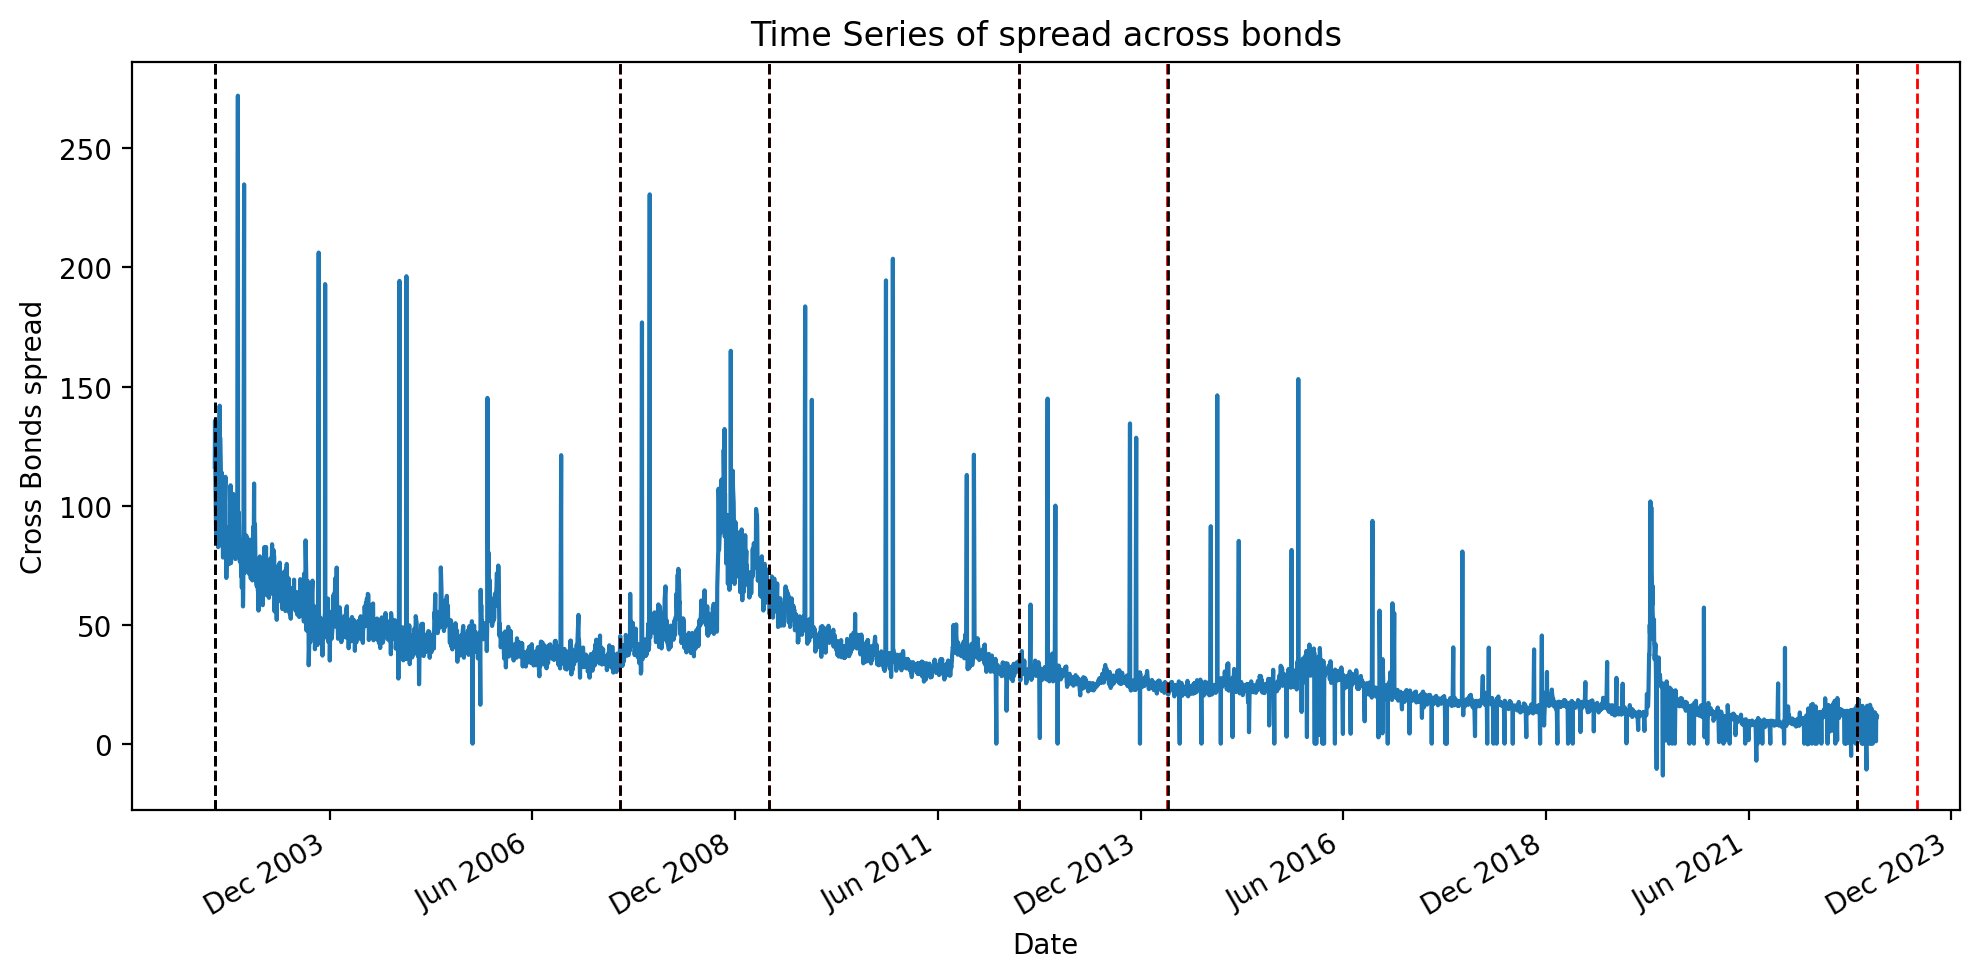

In [16]:
plot_summary_stats(summary_stats, 'spread')

- Higher bid-ask spreads typically indicate lower liquidity, meaning there are fewer buyers and sellers. This can make it more difficult to trade without impacting the price. Conversely, lower spreads suggest better liquidity, where bonds can be bought and sold more easily with less impact on the price.
- From the time series, we can see several spikes. Peaks in the bid-ask spread can correspond to times of financial stress or uncertainty, when liquidity providers increase their spreads to compensate for higher risk. Periods with consistently higher spreads may align with economic downturns, financial crises, or other market disruptions.
- During the Crisis period, the spread arises, which is consistent with our assumptions above. 
- Oeverall, the spread has a decreasing tendency, with huge spikes occuring less frequently, indicating a more liquid and stable credit market in recent times


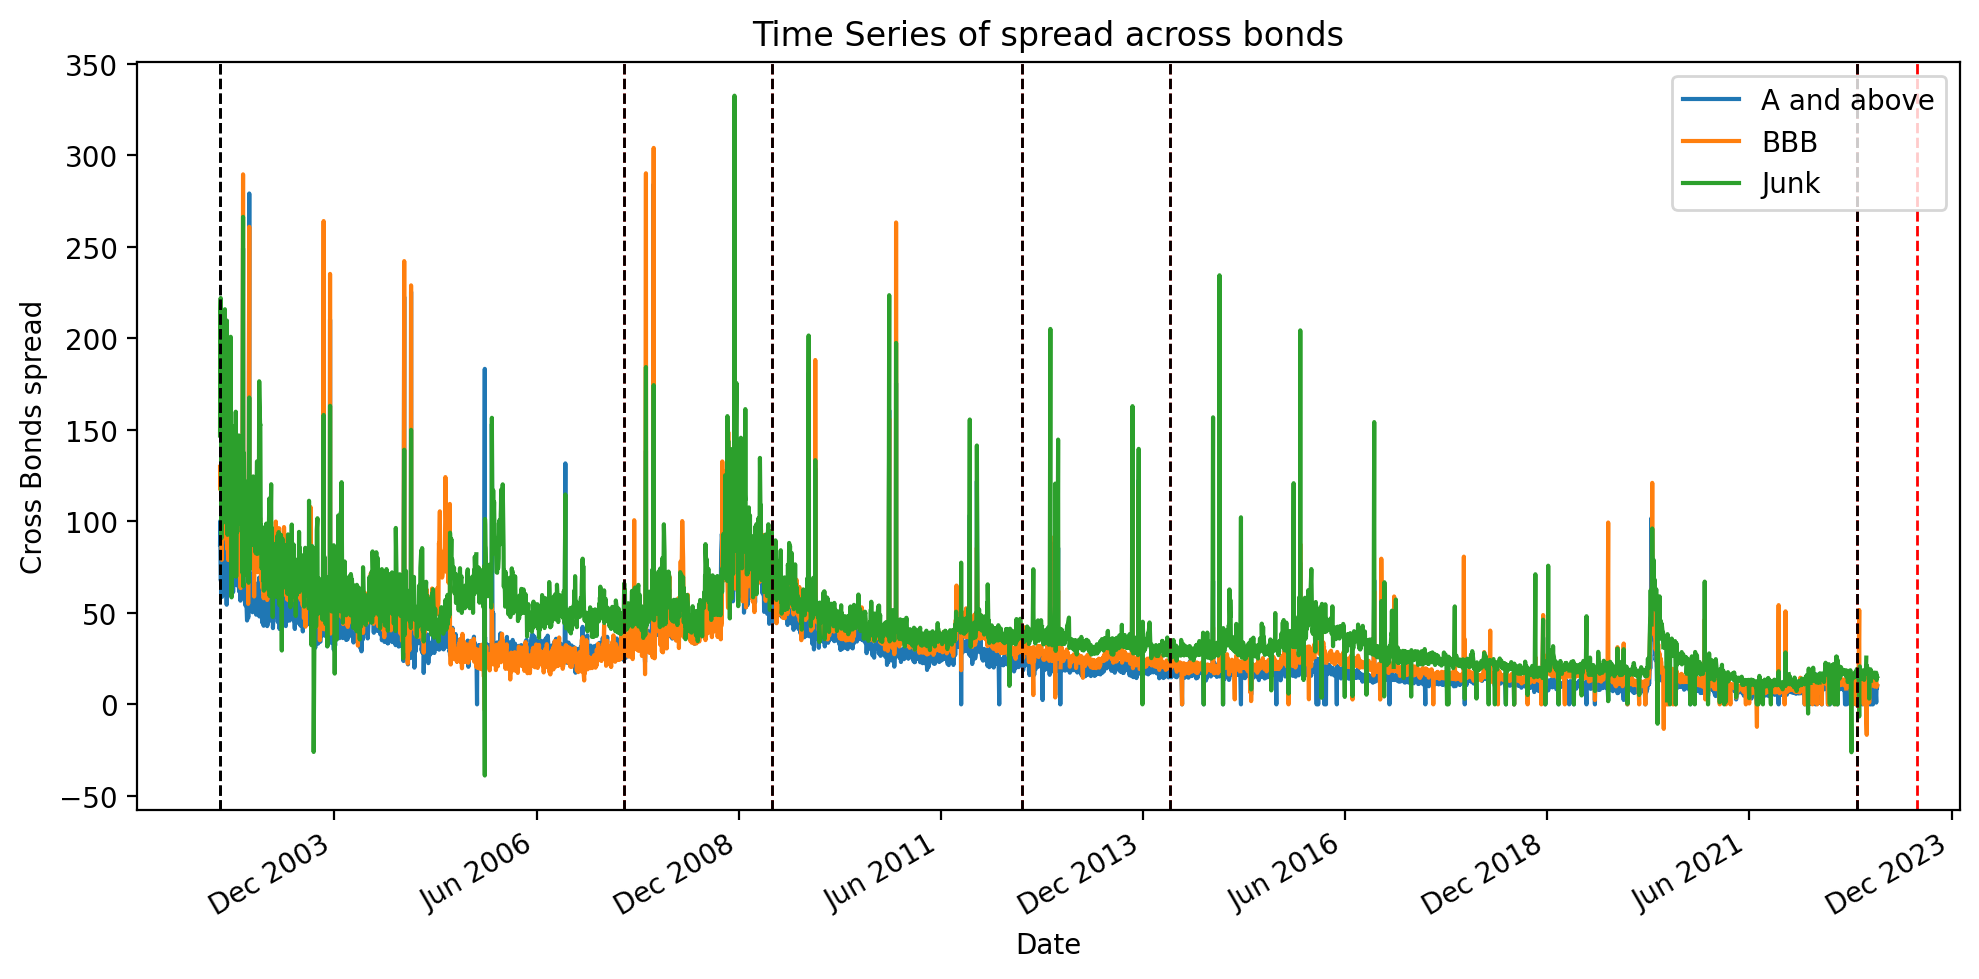

In [17]:
plot_categorized(data_categorized, 'spread', subsamples=SUBSAMPLES)

- Most spikes can be accounted for Junk bonds, while A-and-above bonds have fewer and smaller spikes.
- Overall, the trends of bid and ask spread among the 3 rating categories are extremely similar. However, generally, higher-rated bonds (A-and-above and BBB) have narrower spreads, indicating lower risk and higher liquidity. Meanwhile, Junk bonds typically have wider spreads, signifying higher risk and lower liquidity.

# 2 Daily Return

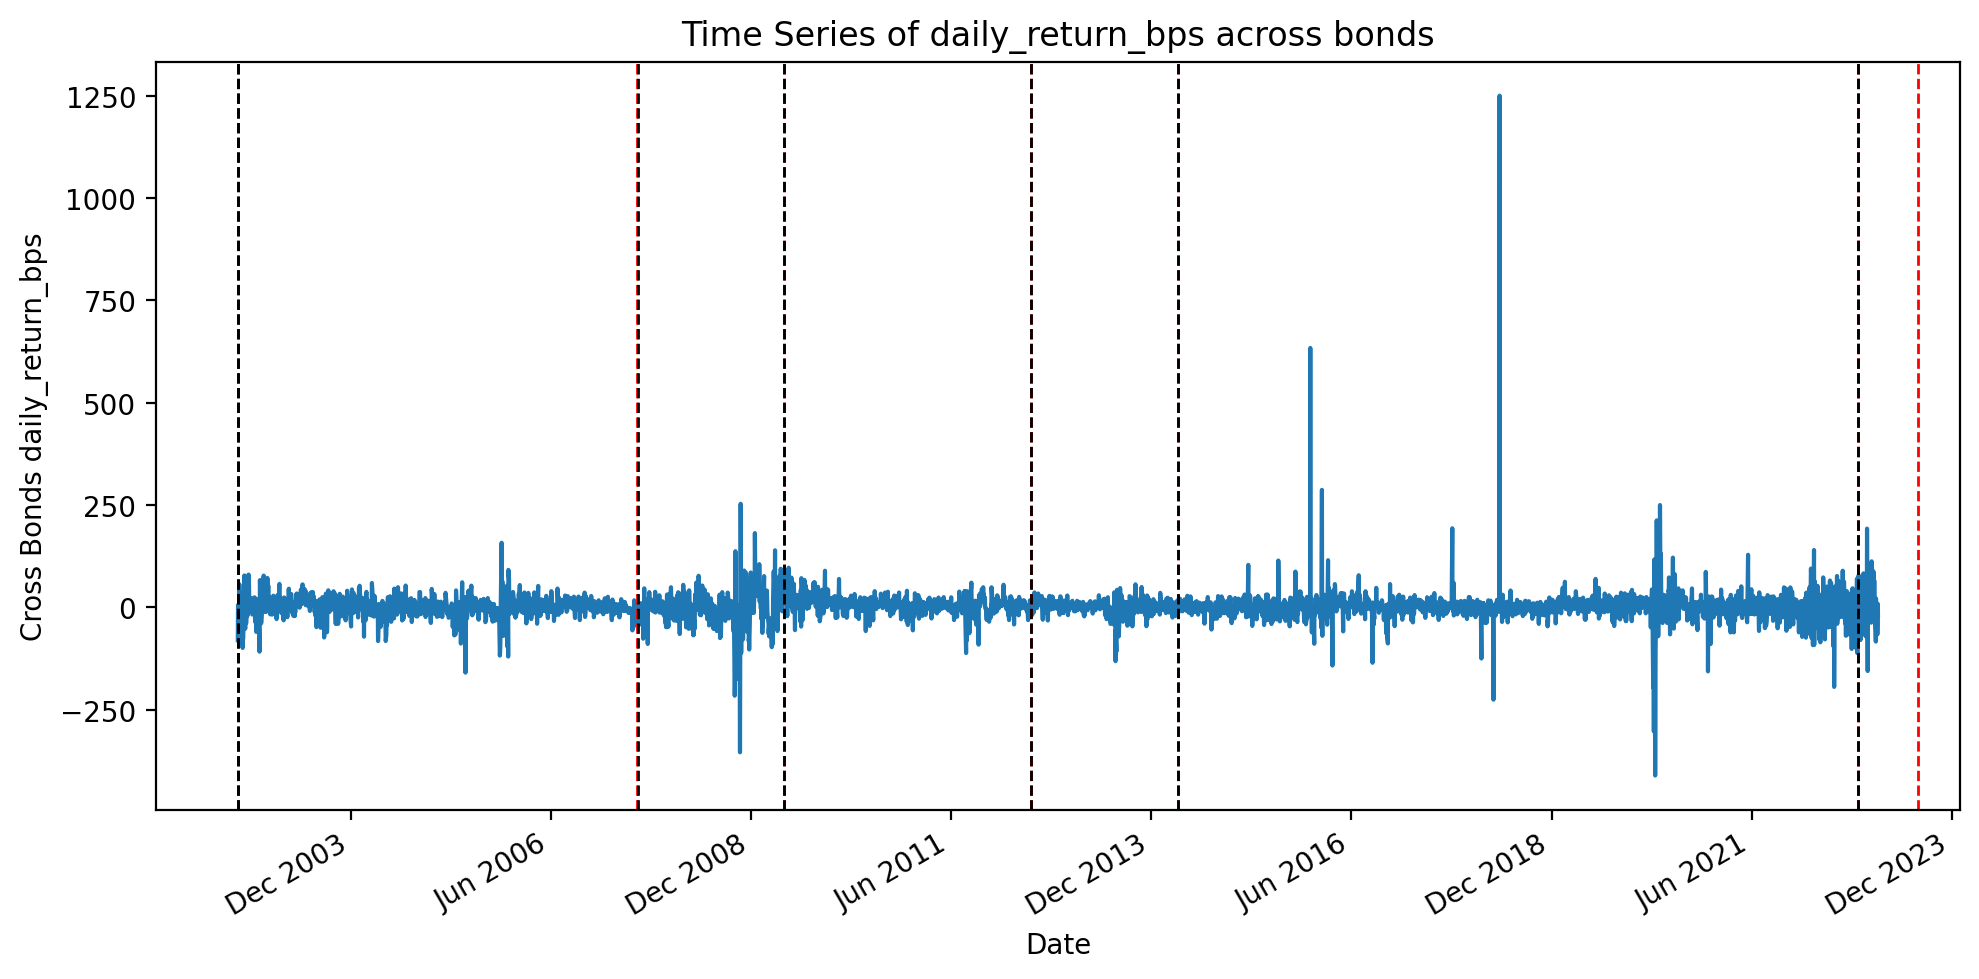

In [18]:
plot_summary_stats(summary_stats, 'daily_return_bps')

- The plot illustrates the volatility of daily returns across bonds. The returns fluctuate around the zero line (which is quite reasonable), with few noticeable spikes both above and below it. 
- During the crisis period, the returns experience higher volatility, which is consistent with a streassful market at that time.

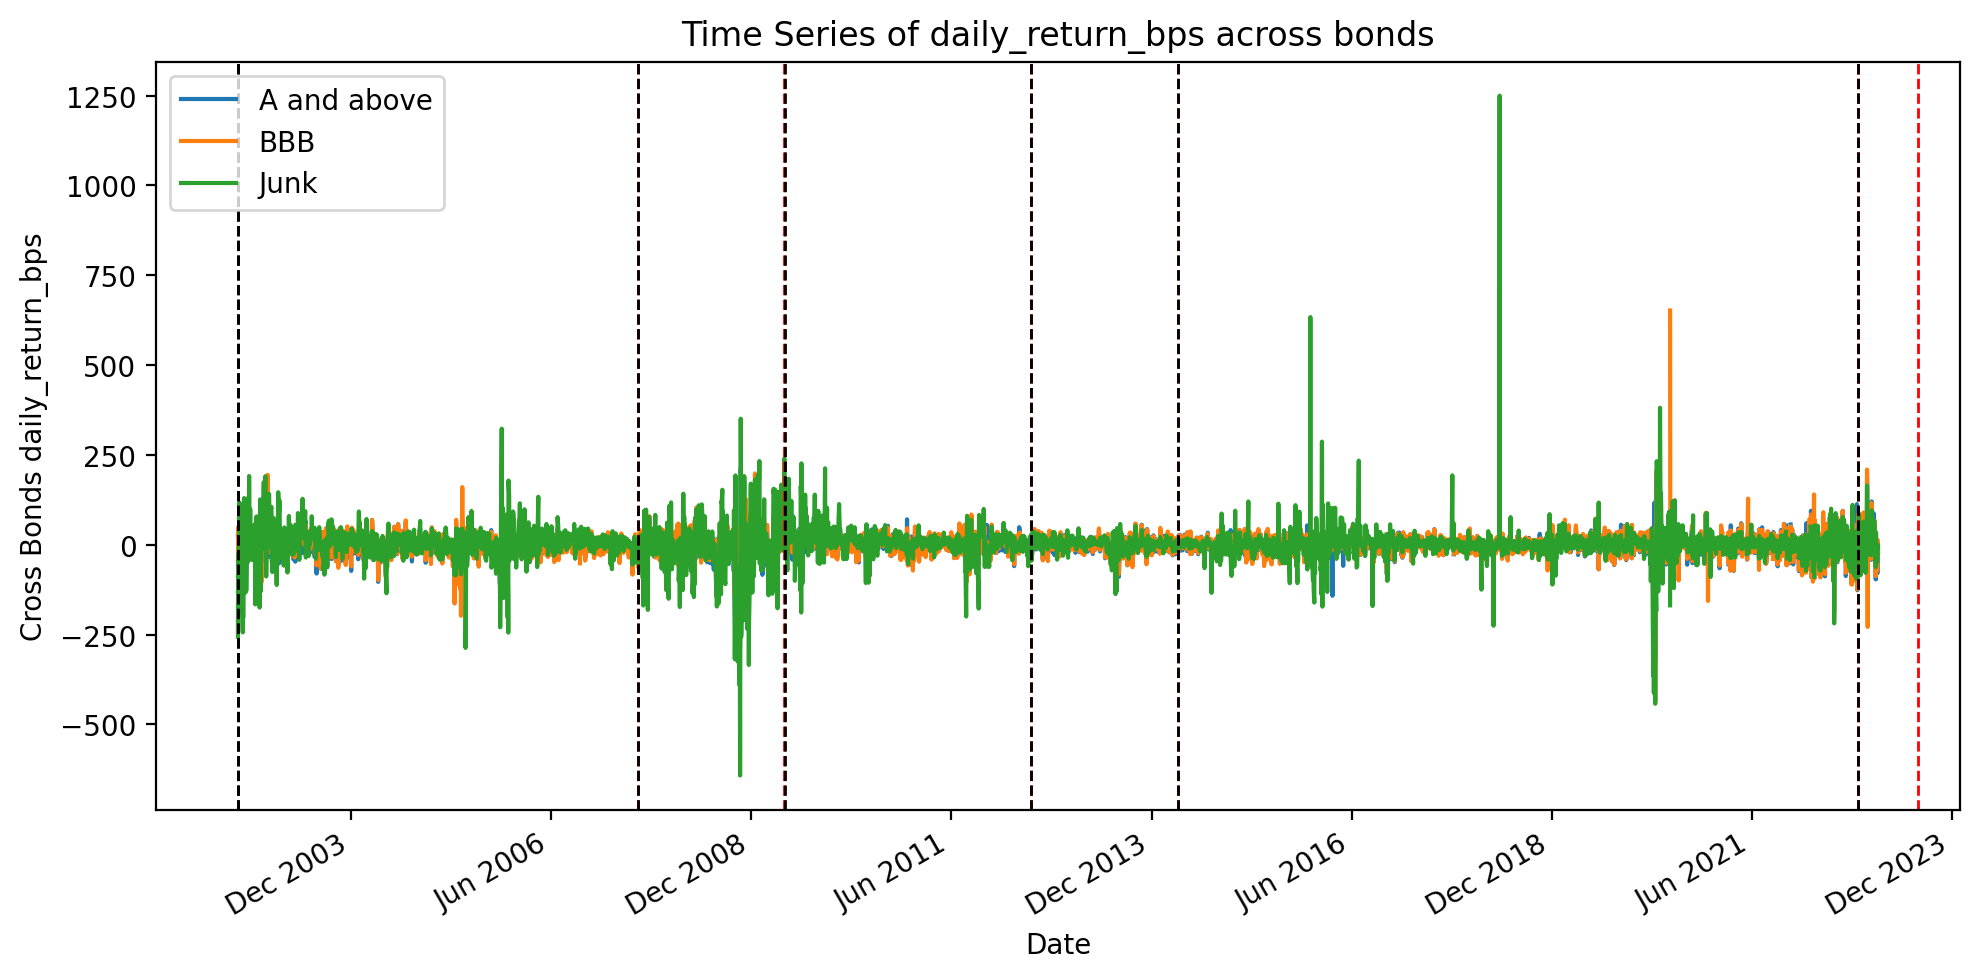

In [19]:
plot_categorized(data_categorized, 'daily_return_bps', subsamples=SUBSAMPLES)

- Spikes in daily returns might correlate with economic news, earnings reports, interest rate changes, or other market-moving events.
Large positive spikes could indicate favorable market conditions or news for the bonds, while negative spikes could point to adverse events.
- Junk bonds show the most significant swings, which is consistent with the higher risk and return volatility associated with lower credit quality. A and above' bonds appear to have the smallest fluctuations, suggesting lower volatility typically associated with higher-rated, more stable bonds.

# 3 Bid and Ask Bias

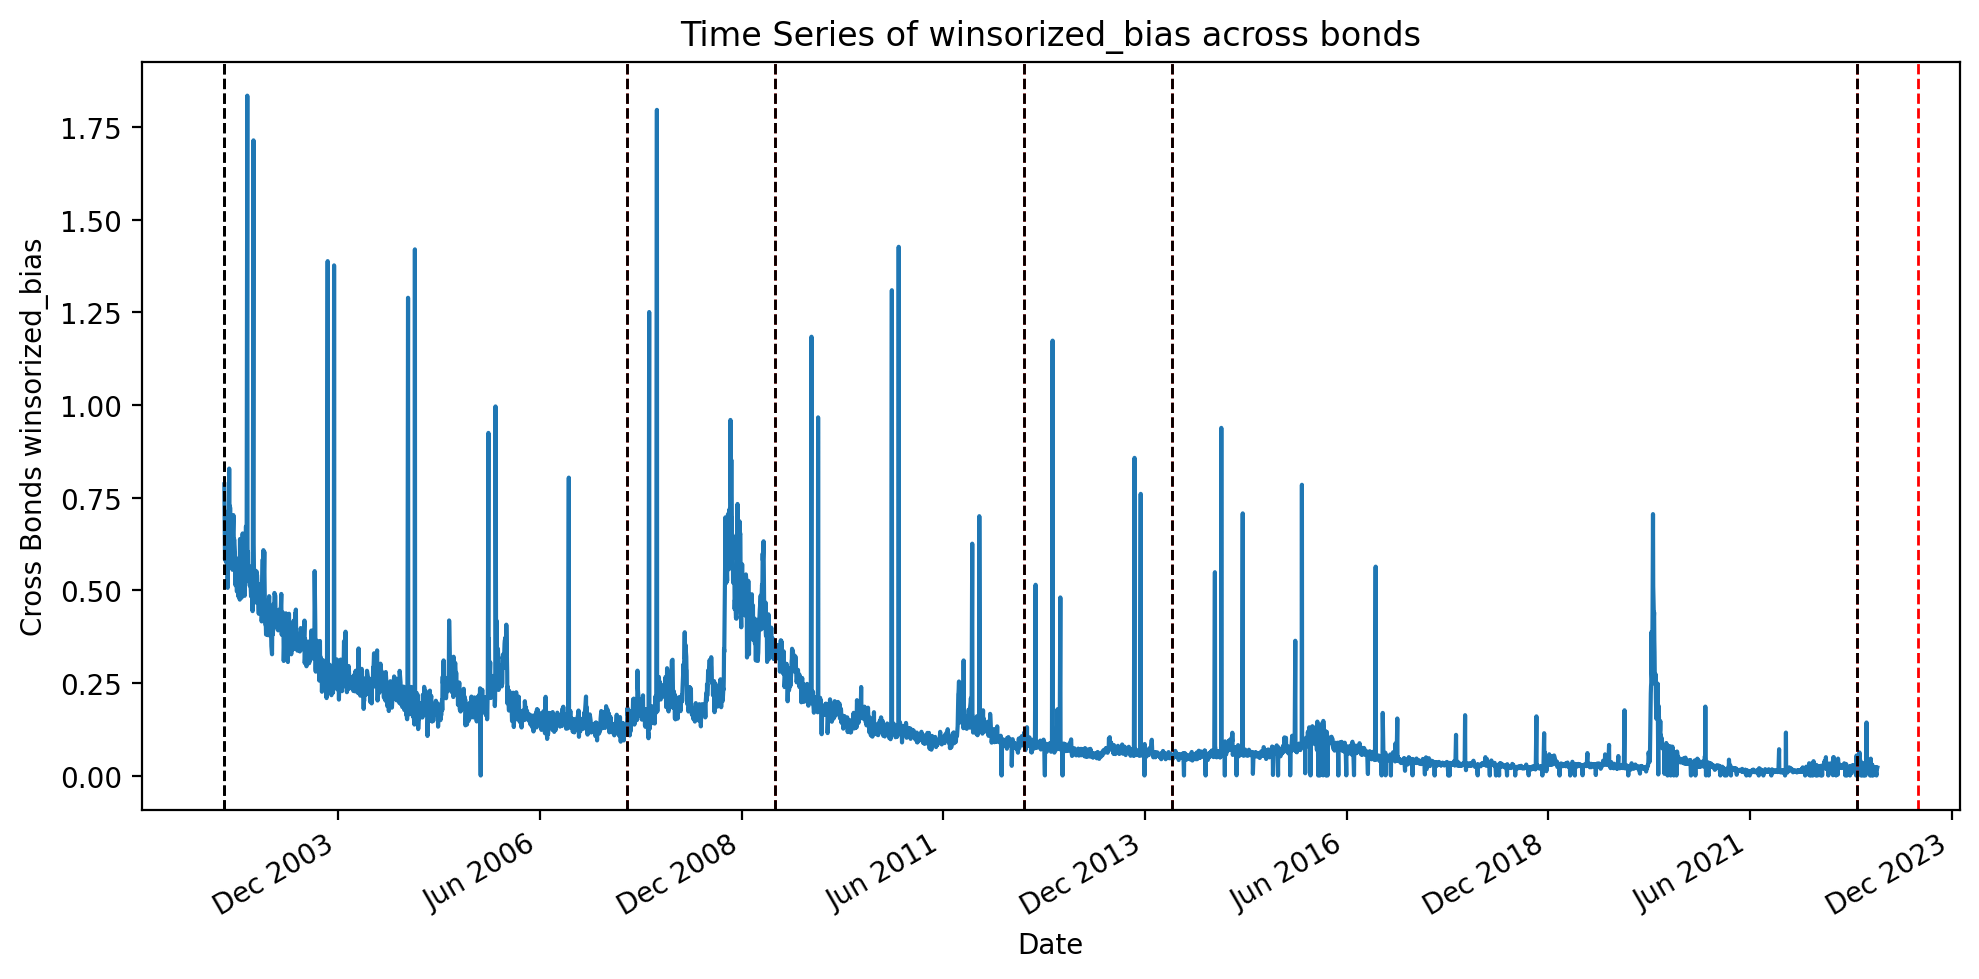

In [20]:
plot_summary_stats(summary_stats, 'winsorized_bias')

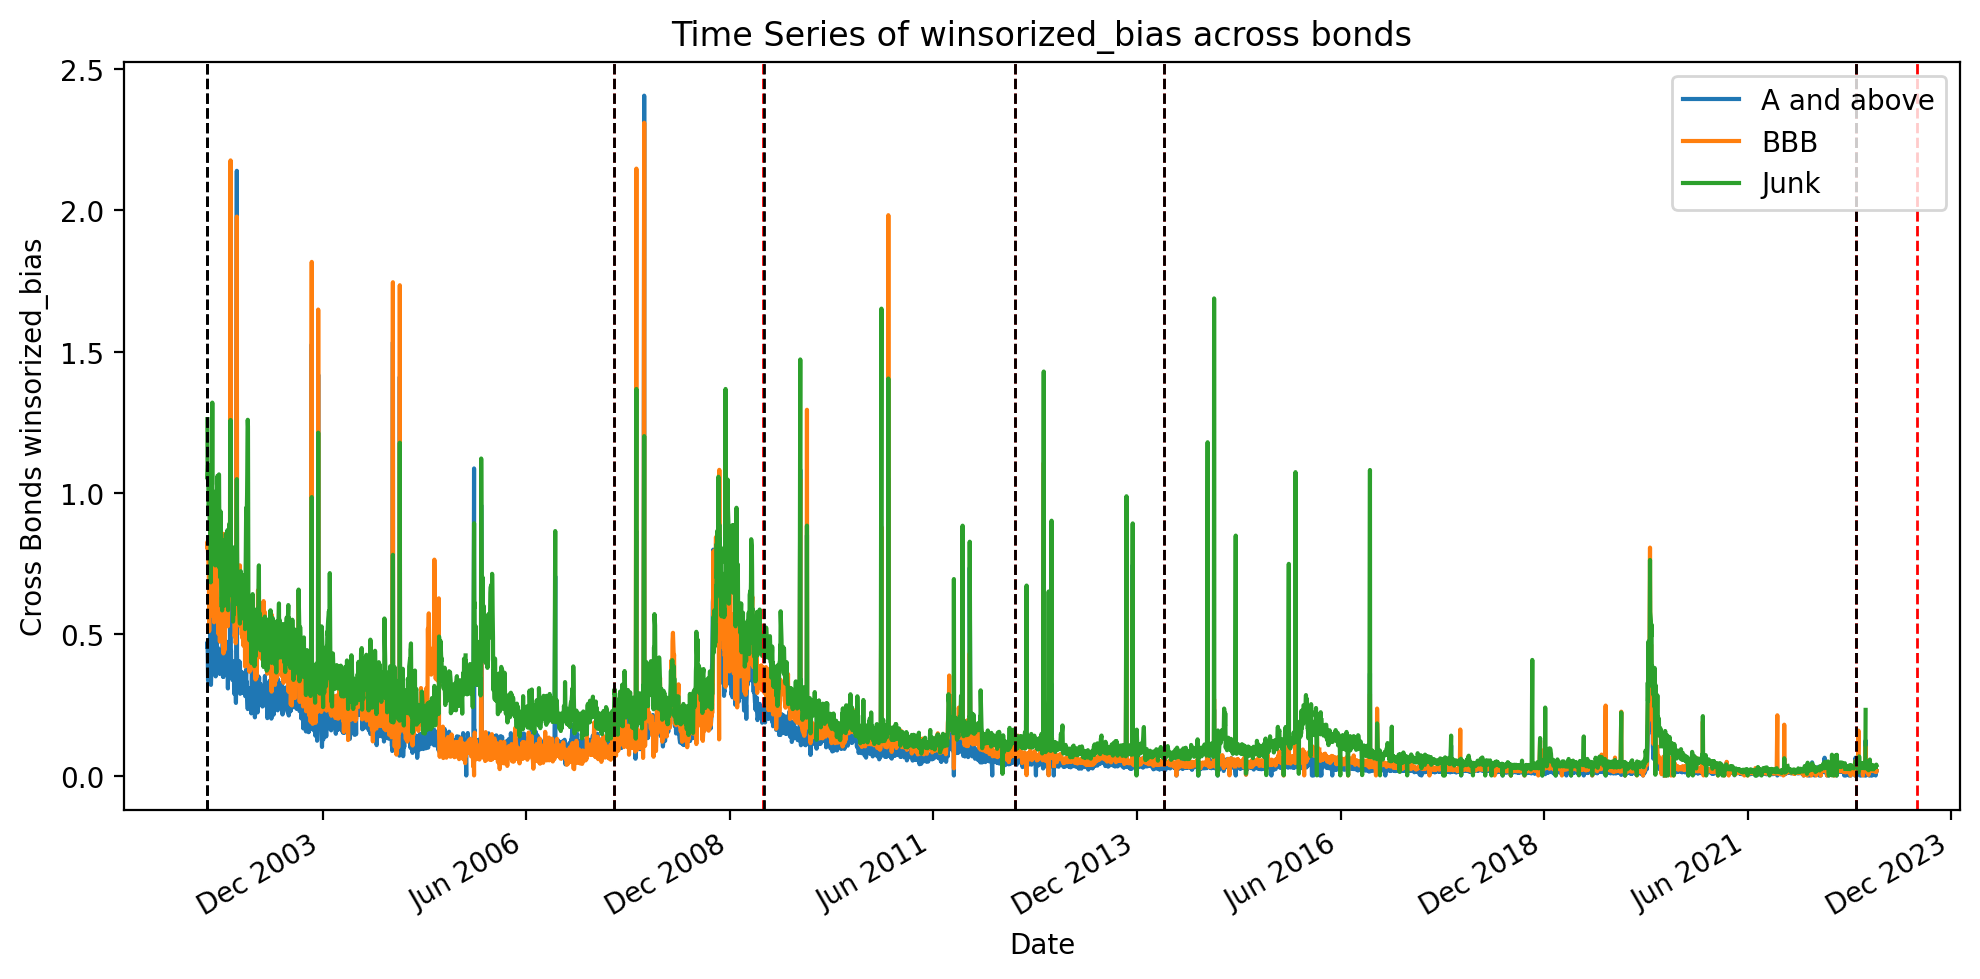

In [21]:
plot_categorized(data_categorized, 'winsorized_bias', subsamples=SUBSAMPLES)

- The results are similar to bid ask spead.

# 4 Credit Spread

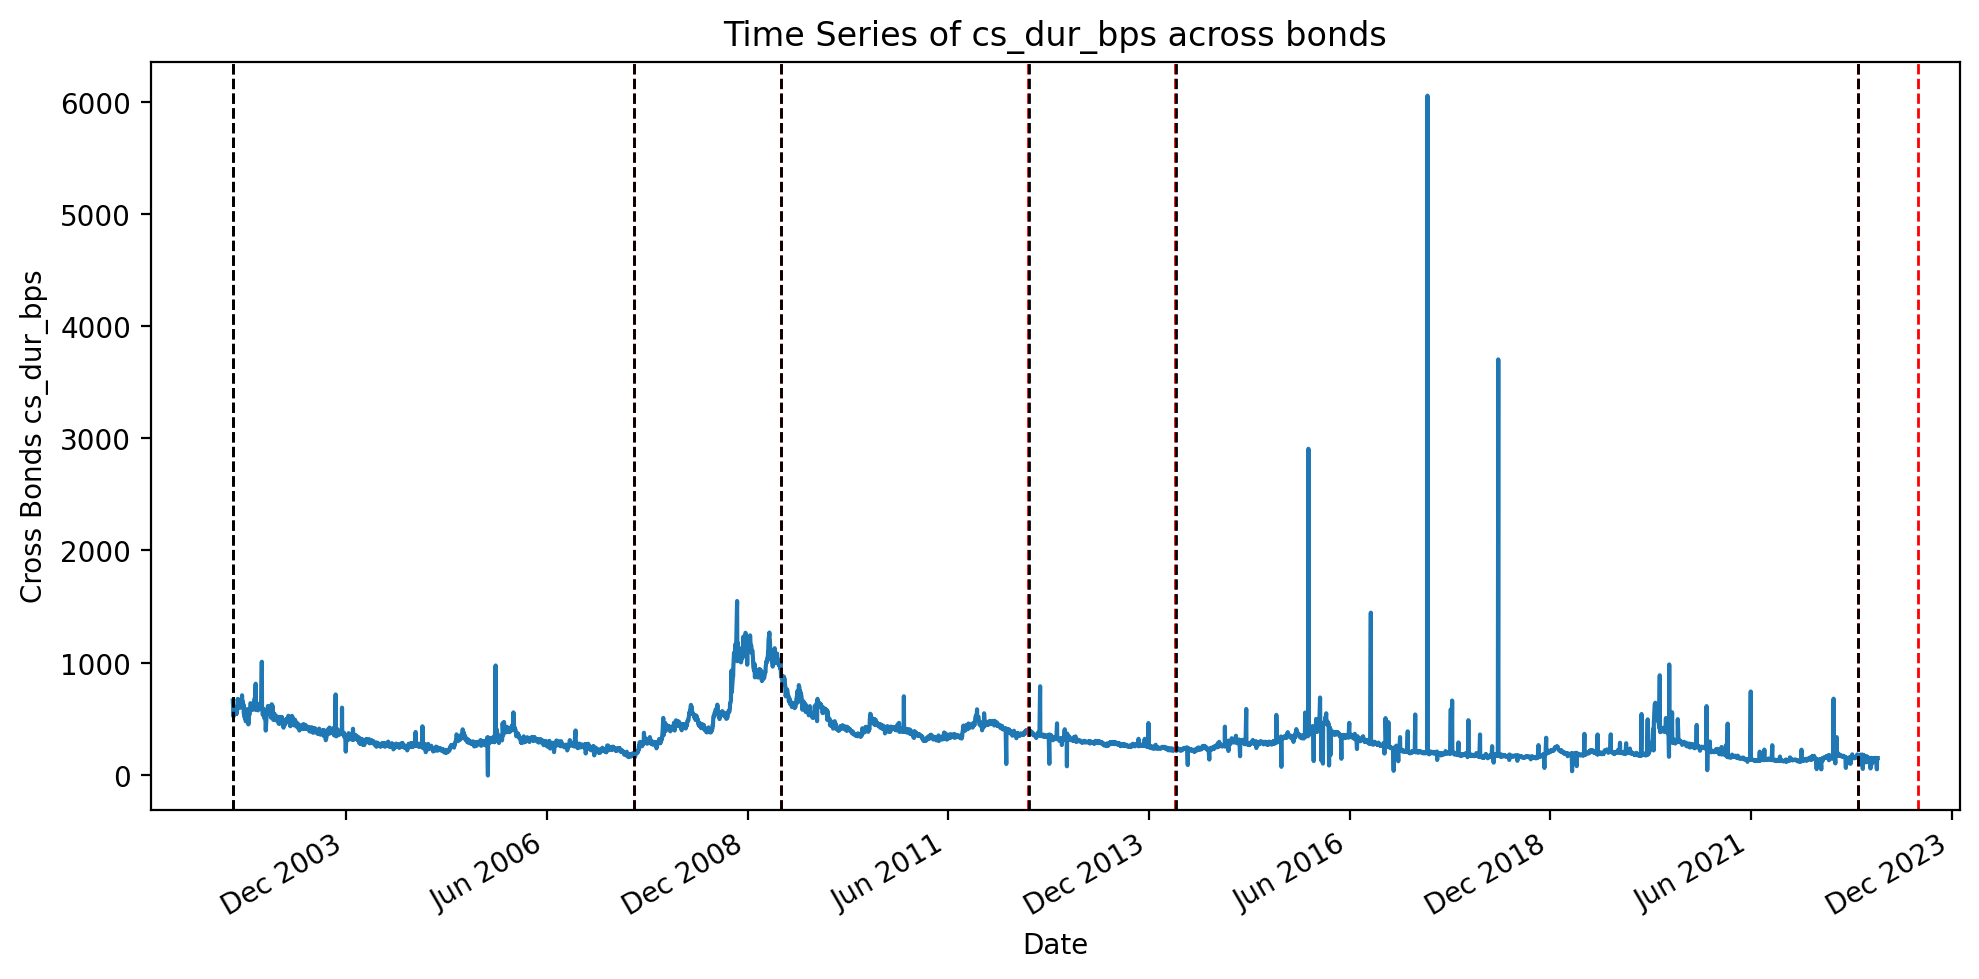

In [22]:
plot_summary_stats(summary_stats, 'cs_dur_bps')

- Credit spreads fluctuate over time but appear relatively stable with occasional spikes, suggesting episodic periods of market stress or increased risk perception. The huge spike in recent times is likely due to extreme outliers.
- The rising of credit spread around 2008 corresponds to the global financial crisis, where credit spreads typically widened significantly due to increased credit risk and market uncertainty.

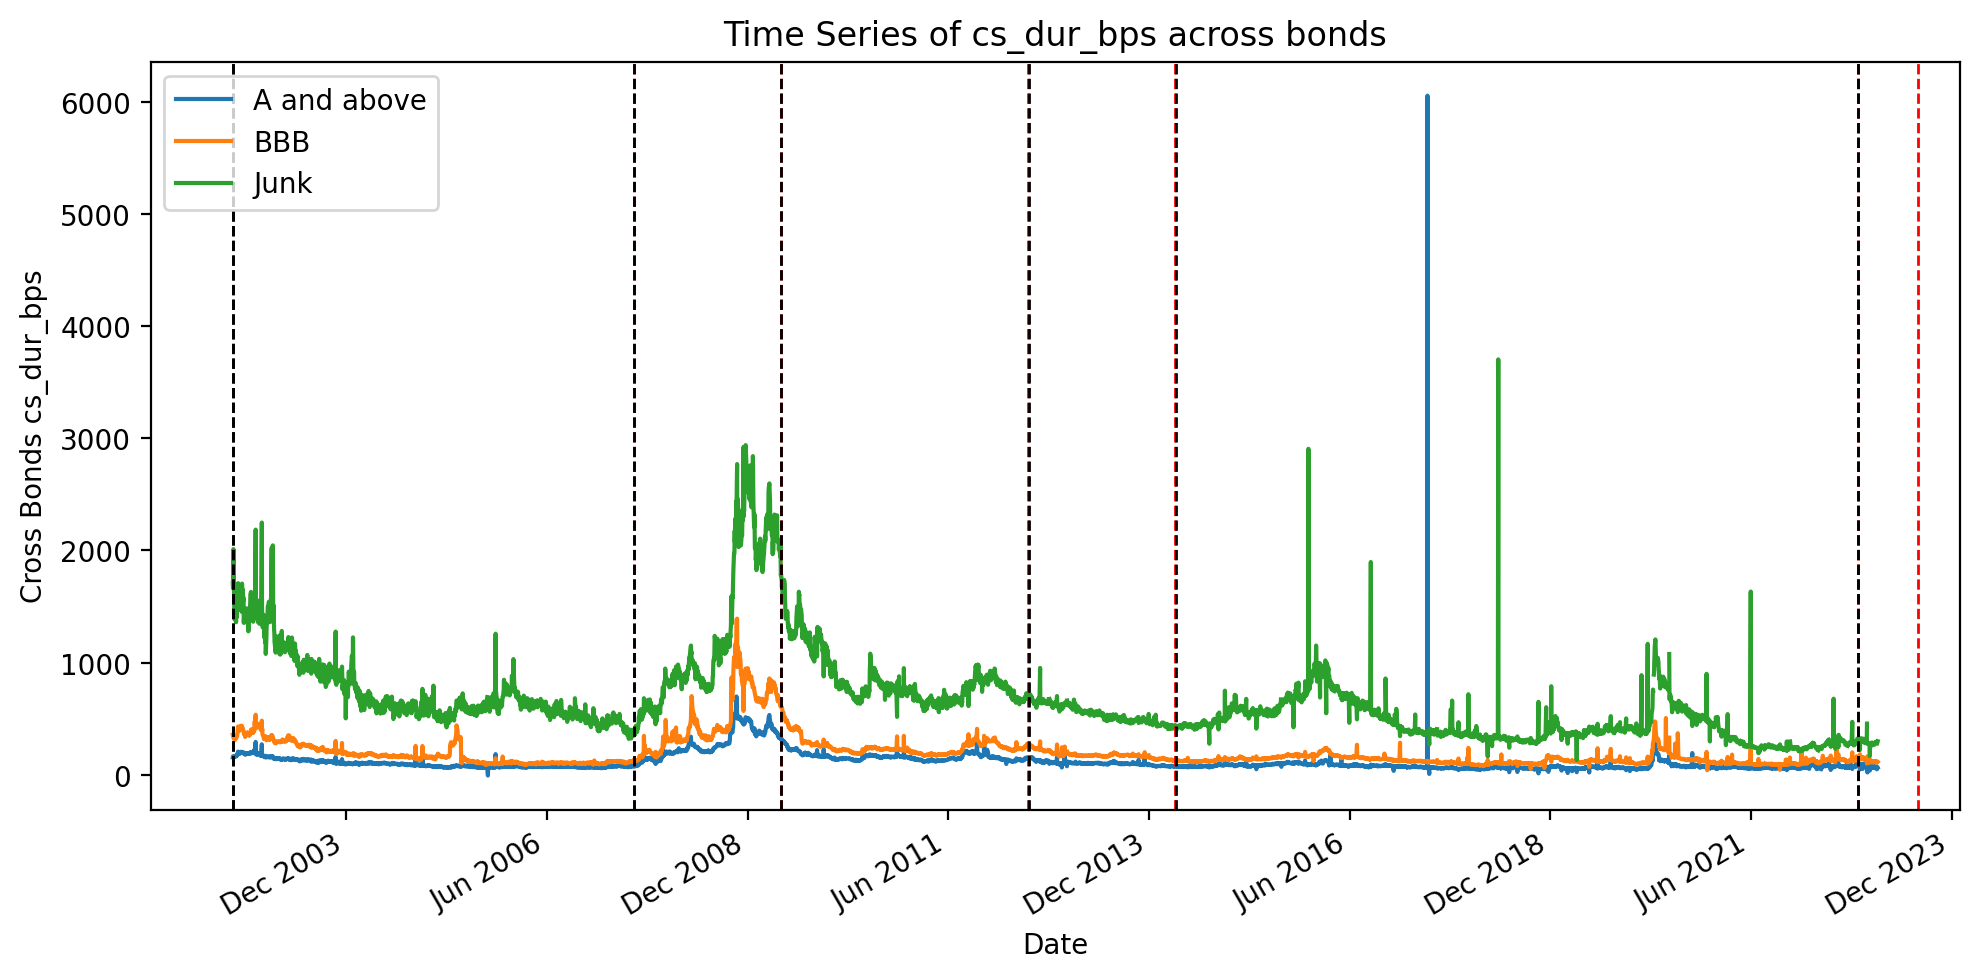

In [23]:
plot_categorized(data_categorized, 'cs_dur_bps', subsamples=SUBSAMPLES)

- The A-and-above category shows consistently lower credit spreads over time, indicative of higher creditworthiness and lower perceived risk by the market. BBB rated bonds have moderate credit spreads, suggesting medium risk. Junk bonds exhibit the highest credit spreads, reflecting their lower credit quality and higher risk.
- Across all bond categories, there are periods where spreads widen significantly, likely indicating systemic market stresses affecting all bond types, albeit to different extents. Junk bonds, which are the most sensitive to economic changes and investor sentiment, show the most significant and frequent spikes. The global financial crisis around 2007-2008 and subsequent European debt crisis are likely to correspond with the spikes in the credit spreads seen in the plot.
- Over the long term, credit spreads for 'A and above' and 'BBB' categories appear to remain relatively stable with fewer and less pronounced spikes, while 'Junk' bonds exhibit more volatility.

# 5 Rating

In [24]:
def get_category_stats(df, subsamples, start_date=None, end_date=None, clean=False):
    '''
    This function is used to calculate the ratios of the 3 rating categories,
    i.e. A and above, BBB, Junk in different periods
    as well as the total counts of the rating dates
    '''
    if clean == True:
        df['date'] = pd.to_datetime(df['date'])
    else:
        df['rating_date'] = pd.to_datetime(df['rating_date'])
        
    if not start_date:
        start_date = START_DATE
    if not end_date:
        if clean == True:
            end_date = df['date'].max()
        else:
            end_date = df['rating_date'].max()
    subsamples['Up to latest'] = (start_date, end_date)

    category_ratios = pd.DataFrame()
    rating_nums_dict = {}

    for subsample_name, (start_date, end_date) in subsamples.items():
        if clean == True:
            subsample_df = df[(df['date'] >= pd.to_datetime(start_date)) & (df['date'] <= pd.to_datetime(end_date))]
        else:
            subsample_df = df[(df['rating_date'] >= pd.to_datetime(start_date)) & (df['rating_date'] <= pd.to_datetime(end_date))]
            
        category_counts = subsample_df['category'].value_counts()
        category_ratio = category_counts / category_counts.sum()
        category_ratios[subsample_name] = category_ratio
        rating_nums_dict[subsample_name] = subsample_df.shape[0]

    rating_nums_df = pd.DataFrame(list(rating_nums_dict.items())).rename(columns={0:'category',1:'Total Counts'}).set_index('category')
    rating_stats = pd.concat([category_ratios.T, rating_nums_df], axis=1)

    rating_stats = rating_stats[['A and above', 'BBB', 'Junk', 'Total Counts']]
    
    return rating_stats

In [25]:
def plot_rating(df, clean=False):
    '''
    This function is used to plot the proportions of the 3 rating categories,
    i.e. A and above, BBB, Junk in different periods
    and the total counts of the rating dates
    '''

    fig, ax1 = plt.subplots(figsize=(10, 6), dpi=200)

    for column in df.columns[:-1]: 
        ax1.plot(df.index, df[column], label=column)

    ax1.set_xlabel('Category')
    ax1.set_ylabel('Proportion', color='tab:red')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    ax2 = ax1.twinx()

    ax2.bar(df.index, df['Total Counts'], color='grey', alpha=0.6, label='Total Counts')

    ax2.set_ylabel('Total Counts', color='tab:grey')
    ax2.tick_params(axis='y', labelcolor='tab:grey')


    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc='upper left')

    if clean == True:
        plt.title('Rating Category Proportions and Total Counts with Cleaned Data')
    else:
        plt.title('Rating Category Proportions and Total Counts with Rating Data')

    plt.show()

In [26]:
rating = pd.read_csv('..'/ Path(DATA_DIR) / 'pulled' / 'rating.csv')
rating.head()

,issue_id,rating_type,rating_date,rating,complete_cusip,offering_date,spr,category,mr
0,197294.0000,SPR,2004-11-09,B-,000305AA0,2004-11-10,16.0000,Junk,NaN
1,197294.0000,MR,2004-11-10,Caa1,000305AA0,2004-11-10,17.0000,Junk,17.0000
2,197294.0000,SPR,2006-06-05,CCC+,000305AA0,2004-11-10,17.0000,Junk,NaN
3,197294.0000,SPR,2009-09-04,CCC,000305AA0,2004-11-10,18.0000,Junk,NaN
4,307353.0000,SPR,2004-11-09,B-,000305AB8,2005-08-31,16.0000,Junk,NaN


In [27]:
rating_stats = get_category_stats(rating, subsamples=SUBSAMPLES, clean=False)
rating_stats

,A and above,BBB,Junk,Total Counts
Full sample,0.5960,0.1819,0.2221,830955
Pre-crisis,0.6237,0.1578,0.2185,233819
Crisis,0.6212,0.1599,0.2189,110961
Post-Crisis,0.6846,0.0999,0.2156,119859
Basel II.5 & III,0.5894,0.2041,0.2066,67101
Post-Volcker,0.5311,0.2368,0.2321,299215
Recent,0.6365,0.2178,0.1457,26275
Up to latest,0.5971,0.1830,0.2199,857776


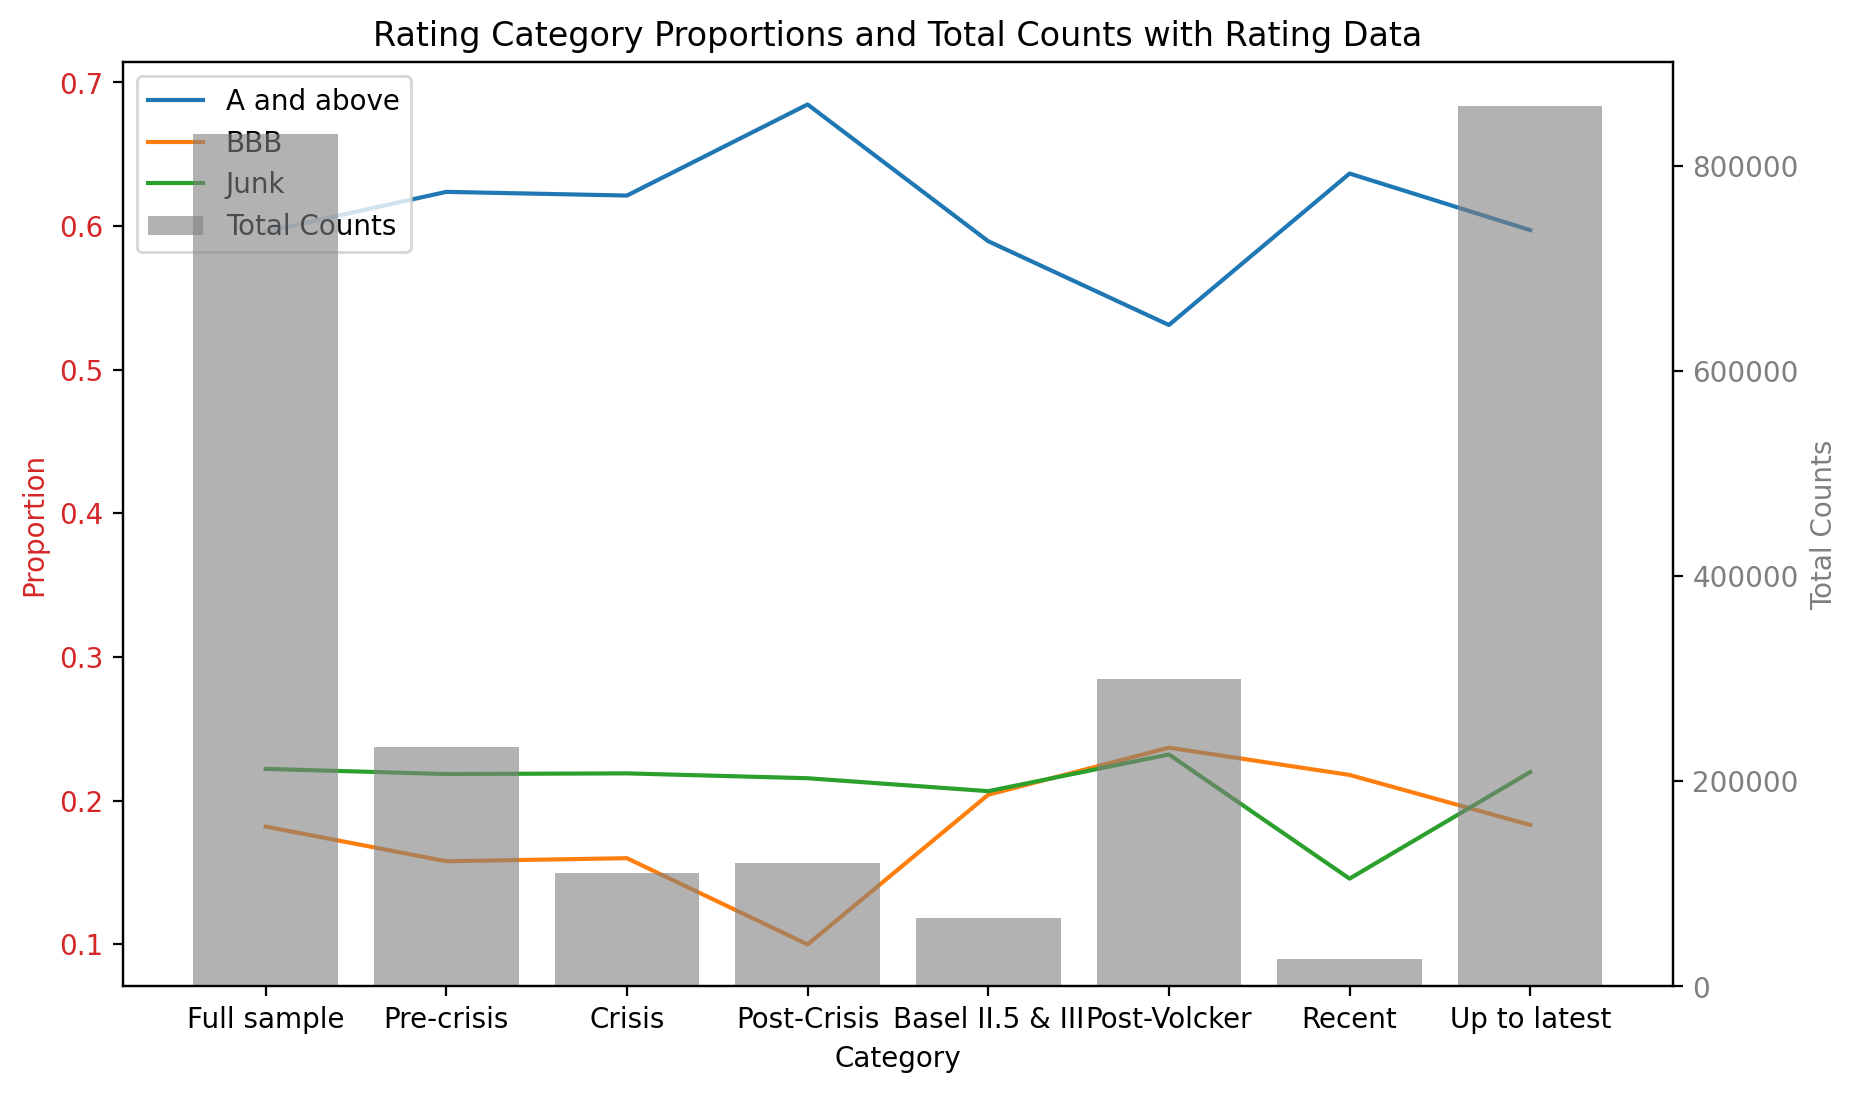

In [28]:
plot_rating(rating_stats,clean=False)

In [29]:
rating_stats_clean = get_category_stats(daily_data, subsamples=SUBSAMPLES, clean=True)
rating_stats_clean

,A and above,BBB,Junk,Total Counts
Full sample,0.2893,0.3707,0.3400,13117643
Pre-crisis,0.4255,0.2328,0.3417,1823021
Crisis,0.4752,0.2221,0.3027,709614
Post-Crisis,0.3262,0.3055,0.3682,1909863
Basel II.5 & III,0.2529,0.3874,0.3597,1165050
Post-Volcker,0.2349,0.4322,0.3328,7510095
Recent,0.2613,0.4913,0.2474,292342
Up to latest,0.2887,0.3733,0.3380,13409985


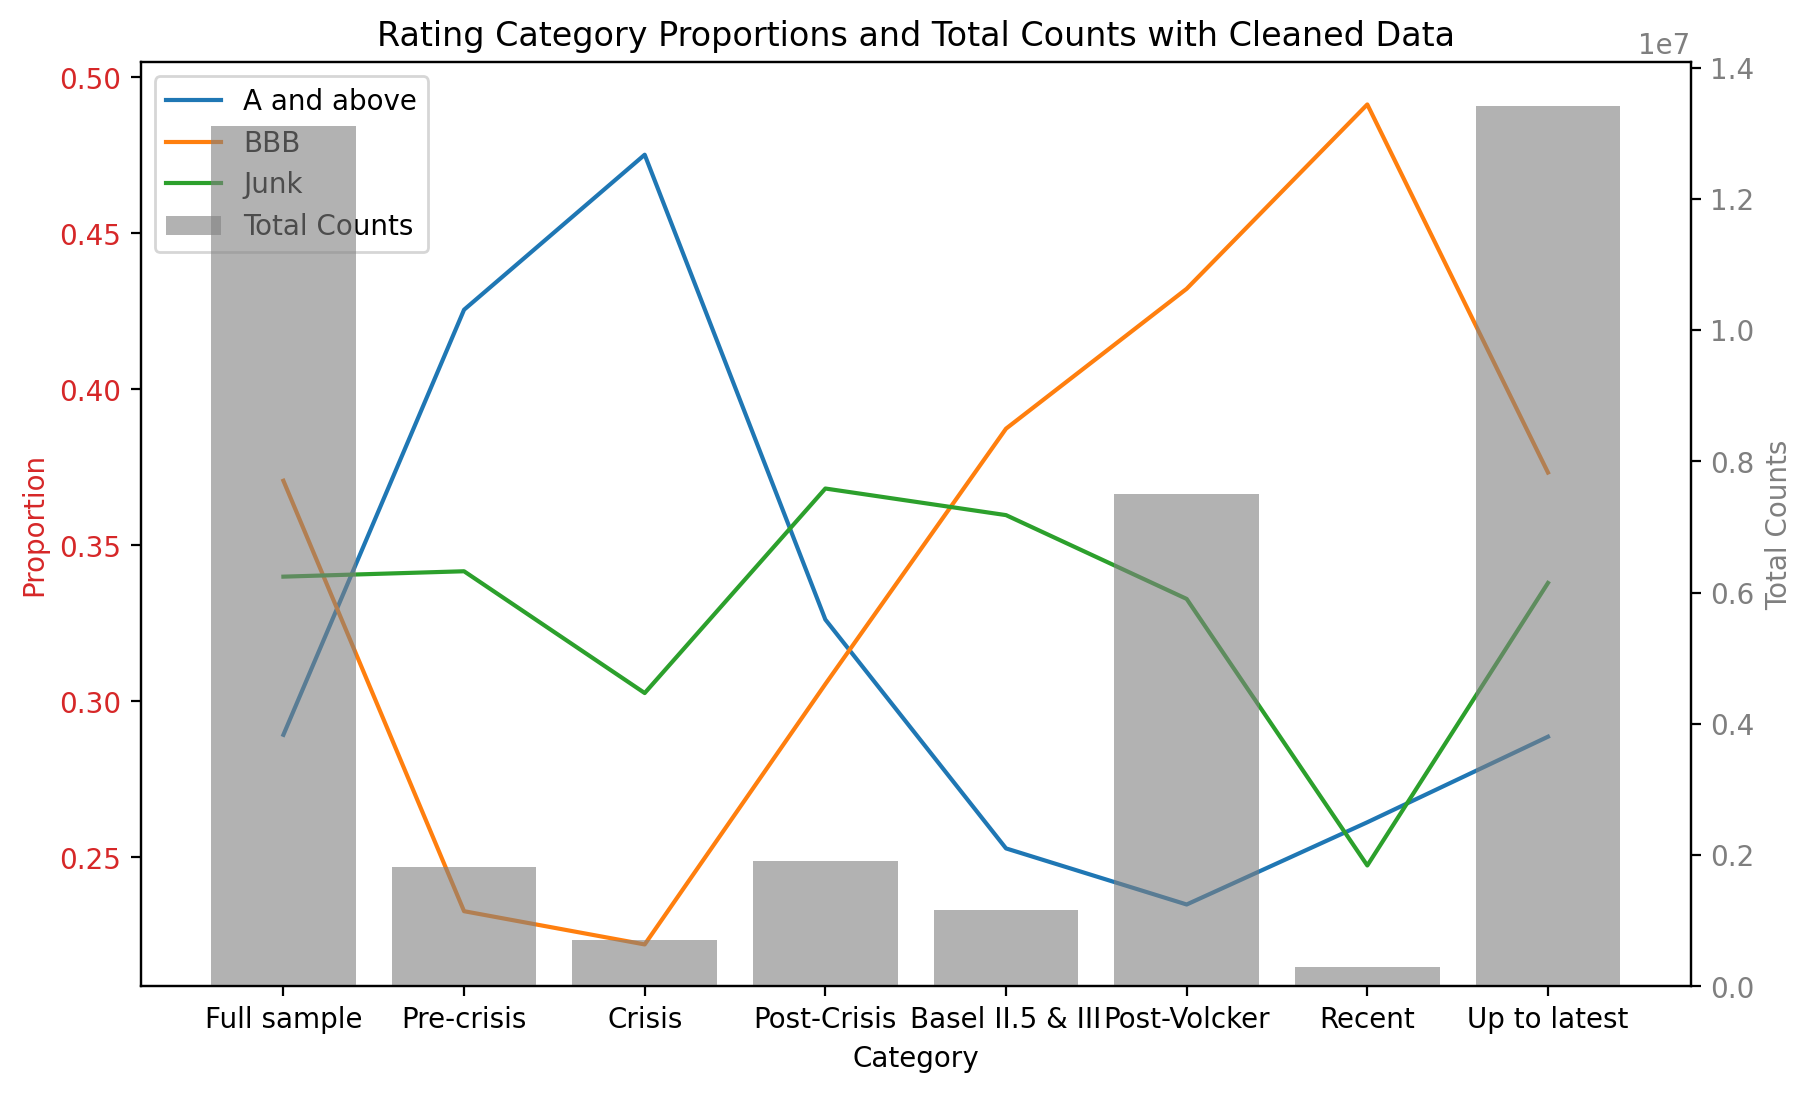

In [30]:
plot_rating(rating_stats_clean,clean=True)

### Conclusion:

- Note that ```rating``` is the rating data retreived from WRDS and processed by ```load_rating.py```, thus ```rating_stats``` is derived from a much larger sample while the cleaned data ```daily.csv``` tilts toward a more liquid sample by filtering out less frequntly traded bonds. However, the ratios show similar tendencies along the timeframe, with a decreasing ratio of A-and-above and an increasing ratio of BBB during the Post-Crisis to Post-Volcker periods.

- In cleaned data, the proportion of BBB category is higher than raw data, which might indicate that the our data focuses more on BBB category bonds. However, as the cleaned data is derived trading data, which naturally has more trade dates than the rating dates form the rating data, it could also indicates for a higher frequency of trading in BBB category bonds.

- In raw rating data, the proportion remains rather steady, but it is noticeable that an increasing ratio of BBB is accompnied by a decreasing ratio of A-and-above, which might indicates that the bond is more likely to transform between these 2 categories.
